# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

## to do:

split output of magnaprobe and GEM2 data into two sessions

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [3]:
## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [221]:
glon, glat,gtimes = readbasegps("/mnt/documents/JC2-2/P9-06092021/gnss/base3-near/kppp/07092021-base3-day2.pos")

['2021/09/07 07:29:19.0000000' '2021/09/07 07:29:19.5000000'
 '2021/09/07 07:29:20.0000000' '2021/09/07 07:29:20.5000000']


In [222]:
glat[0:5]

array([85.49954366, 85.49954922, 85.49955017, 85.49955118, 85.49955212])

In [223]:
glon[0:5]

array([7.15307125, 7.15305899, 7.15305009, 7.15304107, 7.15303168])

In [224]:
gtimes[0]

datetime.datetime(2021, 9, 7, 7, 29, 19)

In [225]:
gtimes[-1]

datetime.datetime(2021, 9, 7, 14, 16, 32, 500000)

In [226]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
    
gnssdayseconds = np.array(gnssdayseconds)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to NSIDC north polar stereo (EPSG 3413)

In [227]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [228]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

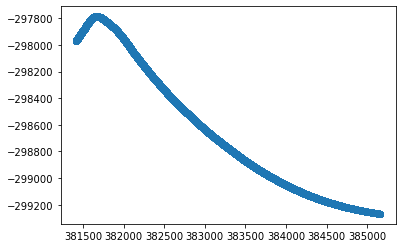

In [12]:
plt.scatter(gnssutm[0], gnssutm[1])

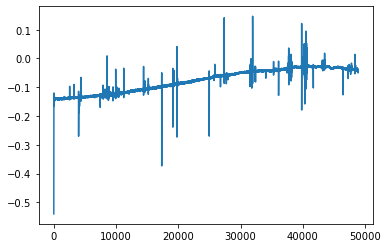

In [13]:
plt.plot(np.diff(gnssutm[0]))

In [14]:
gnssdayseconds[0:5]

array([26959. , 26959.5, 26960. , 26960.5, 26961. ])

## Load  GEM2 data to be drift corrected

In [15]:
gem2inputfile = "/mnt/documents/JC2-2/P9-06092021/gem2/07092021/JC2-2-P9-morning-transect-07092021-gem2-531-channel-thickness.csv"

In [16]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [17]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [18]:
gem2data

time   record_id   longitude   latitude   xc  \
2      2021-09-07T08:18:40.523437           2    7.106673  85.506316  0.0   
3      2021-09-07T08:18:40.617187           3    7.106672  85.506316  0.0   
4      2021-09-07T08:18:40.718750           4    7.106670  85.506316  0.0   
5      2021-09-07T08:18:40.820312           5    7.106669  85.506316  0.0   
6      2021-09-07T08:18:40.921875           6    7.106668  85.506316  0.0   
...                           ...         ...         ...        ...  ...   
17661  2021-09-07T09:14:08.562500       17661    7.071204  85.513838  0.0   
17662  2021-09-07T09:14:08.664062       17662    7.071203  85.513838  0.0   
17663  2021-09-07T09:14:08.757812       17663    7.071202  85.513838  0.0   
17664  2021-09-07T09:14:08.859375       17664    7.071201  85.513838  0.0   
17665  2021-09-07T09:14:08.960937       17665    7.071200  85.513838  0.0   

        yc   f450Hz_hcp_i  f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
2      0.0          1.954         1.445           1.531           1.491   
3      0.0          0.849         1.422           1.567           1.501   
4      0.0          0.597         1.418           1.511           1.507   
5      0.0          0.903         1.464           1.557           1.505   
6      0.0          1.187         1.468           1.510           1.520   
...    ...            ...           ...             ...             ...   
17661  0.0          2.453         1.578           1.538           1.495   
17662  0.0          1.507         1.589           1.506           1.495   
17663  0.0          1.836         1.463           1.494           1.496   
17664  0.0          2.376         1.482           1.537           1.516   
17665  0.0          1.906         1.495           1.514           1.513   

        f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
2               1.504           1.494            1.501            1.497   
3               1.491           1.494            1.502            1.496   
4               1.514           1.496            1.503            1.495   
5               1.522           1.496            1.501            1.497   
6               1.513           1.503            1.501            1.498   
...               ...             ...              ...              ...   
17661           1.520           1.492            1.499            1.491   
17662           1.519           1.496            1.499            1.491   
17663           1.529           1.503            1.499            1.492   
17664           1.532           1.508            1.498            1.491   
17665           1.529           1.503            1.502            1.491   

        f63030Hz_hcp_i  f63030Hz_hcp_q  
2                1.504           1.488  
3                1.504           1.490  
4                1.504           1.492  
5                1.504           1.491  
6                1.503           1.489  
...                ...             ...  
17661            1.505           1.481  
17662            1.504           1.483  
17663            1.504           1.480  
17664            1.504           1.480  
17665            1.505           1.480  

[17568 rows x 16 columns]

In [19]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [20]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [21]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

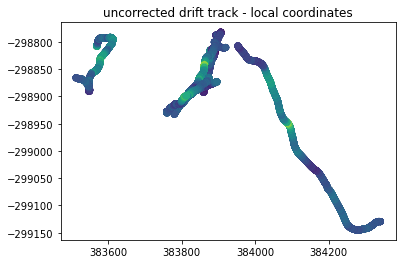

In [22]:
plt.scatter(gem2easting, gem2northing, c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [23]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour))*3600.0) + (int(minute) * 60.0) + float(second))
    
gem2dayseconds = np.array(gem2dayseconds)

In [24]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [25]:
gem2times[0]

'2021-09-07T08:18:40.523437'

In [26]:
gtimes[0]

datetime.datetime(2021, 9, 7, 7, 29, 19)

In [27]:
gnssdayseconds[0]

26959.0

In [28]:
gem2dayseconds[0]

29920.5234

In [29]:
np.where(gnssdayseconds < gem2dayseconds[0])

(array([   0,    1,    2, ..., 5921, 5922, 5923]),)

In [30]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

29920.5234
5923
12580


In [31]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [32]:
gnss_trimmedtime

array([ 5923,  5924,  5925, ..., 12578, 12579, 12580])

In [33]:
start

29920.5234

In [34]:
end

33248.9609

In [35]:
gnssdayseconds = np.array(gnssdayseconds)

In [36]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [37]:
trimmedtime[0]

29920.5

In [38]:
trimmednorth[0]

-299145.79168698535

In [39]:
gem2dayseconds[0]

29920.5234

In [40]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [41]:
timesteps = np.round(timesteps, 4)

In [42]:
timesteps[0]

29920.0

In [43]:
gem2dayseconds[0]

29920.5234

In [44]:
interp_north[0]

-299145.79168698535

In [45]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 4min 55s, sys: 38.6 ms, total: 4min 55s
Wall time: 4min 55s


In [46]:
len(timeindexes)

17568

In [47]:
len(gem2dayseconds)

17568

In [48]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

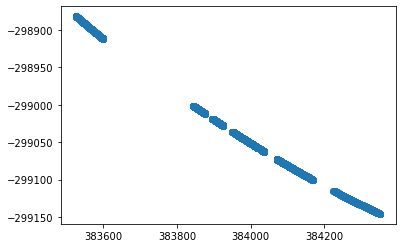

In [49]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [50]:
gnss_gem2_match_eastings[0]

array([384352.7478378])

In [51]:
len(gnss_gem2_match_eastings)

17568

In [52]:
len(gem2easting)

17568

In [53]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [54]:
gnss_gem2_match_eastings[0]

384352.74783780286

In [55]:
gnss_gem2_match_northings[0]

-299145.7902581705

In [56]:
ref_point_east = gnss_gem2_match_eastings[0]
ref_point_north = gnss_gem2_match_northings[1]

In [57]:
ref_point_east

384352.74783780286

In [58]:
ref_point_north

-299145.7845306991

In [59]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [60]:
local_gem2_east[0]

-11.58562513627112

In [61]:
local_gem2_north[0]

16.243400225008372

In [62]:
world_gem2_east = local_gem2_east + ref_point_east
world_gem2_north = local_gem2_north + ref_point_north

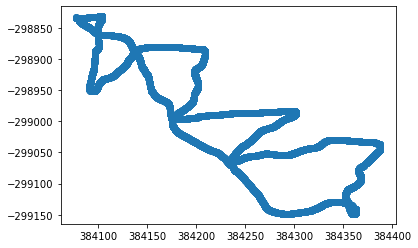

In [63]:
plt.scatter(world_gem2_east, world_gem2_north)

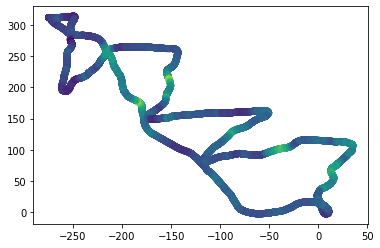

In [64]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [65]:
gem2_header = """AeN JC2-2 2021 P9 GEM2 measurements
GEM2-531 electromagnetic induction sounder
7 September 2021\nAdam Steer / Anca Cristea
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [66]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [67]:
gem2out = gem2data.copy()

In [68]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [69]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [70]:
gem2out.insert(2, "easting", world_gem2_east)

In [71]:
gem2out.insert(3, "northing", world_gem2_north)

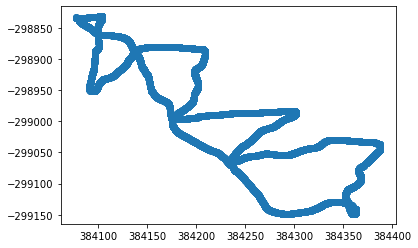

In [72]:
plt.scatter(world_gem2_east, world_gem2_north)

In [73]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [74]:
gem2_output = "/mnt/documents/JC2-2/P9-06092021/gem2/07092021/GEM2data-07092021-driftcorrected-morning.csv"

In [75]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [76]:
gem2out.to_csv(gem2_output, index=False, mode='a')

#### Afternoon transect session

In [77]:
gem2inputfile = "/mnt/documents/JC2-2/P9-06092021/gem2/07092021/JC2-2-P9-afternoon-transect-07092021-gem2-531-channel-thickness.csv"

In [78]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [79]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [80]:
gem2data

time   record_id   longitude   latitude   xc  \
7      2021-09-07T11:31:11.437500           7    7.046150  85.528445  0.0   
8      2021-09-07T11:31:11.539062           8    7.046150  85.528445  0.0   
9      2021-09-07T11:31:11.640625           9    7.046150  85.528445  0.0   
10     2021-09-07T11:31:11.742187          10    7.046150  85.528445  0.0   
11     2021-09-07T11:31:11.835937          11    7.046150  85.528445  0.0   
...                           ...         ...         ...        ...  ...   
31413  2021-09-07T14:01:53.546875       31413    7.012753  85.534289  0.0   
31414  2021-09-07T14:01:53.640625       31414    7.012756  85.534289  0.0   
31415  2021-09-07T14:01:53.750000       31415    7.012760  85.534289  0.0   
31416  2021-09-07T14:01:53.843750       31416    7.012764  85.534289  0.0   
31417  2021-09-07T14:01:53.937500       31417    7.012768  85.534288  0.0   

        yc   f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
7      0.0          1.885         1.554          1.596          1.518   
8      0.0          0.982         1.648          1.402          1.520   
9      0.0          1.717         1.566          1.447          1.485   
10     0.0          2.112         1.459          1.602          1.483   
11     0.0          2.045         1.502          1.631          1.496   
...    ...            ...           ...            ...            ...   
31413  0.0          2.089         1.521          1.467          1.562   
31414  0.0          1.422         1.482          1.423          1.579   
31415  0.0          1.401         1.582          1.417          1.550   
31416  0.0          1.514         1.551          1.500          1.551   
31417  0.0          2.070         1.459          1.512          1.568   

       f5310Hz_hcp_i  f5310Hz_hcp_q  f18330Hz_hcp_i  f18330Hz_hcp_q  \
7              1.504          1.499           1.507           1.488   
8              1.516          1.503           1.505           1.491   
9              1.528          1.503           1.505           1.495   
10             1.534          1.501           1.505           1.496   
11             1.543          1.502           1.504           1.496   
...              ...            ...             ...             ...   
31413          1.551          1.553           1.558           1.560   
31414          1.550          1.558           1.553           1.558   
31415          1.554          1.558           1.546           1.558   
31416          1.550          1.559           1.550           1.559   
31417          1.555          1.562           1.550           1.562   

       f63030Hz_hcp_i  f63030Hz_hcp_q  
7               1.501           1.484  
8               1.501           1.486  
9               1.501           1.487  
10              1.500           1.488  
11              1.500           1.489  
...               ...             ...  
31413           1.554           1.570  
31414           1.552           1.570  
31415           1.552           1.570  
31416           1.555           1.570  
31417           1.557           1.571  

[31053 rows x 16 columns]

In [81]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [82]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [83]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

In [84]:
gem2easting[0]

382131.9940829599

In [85]:
gem2northing[0]

-298058.869696708

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

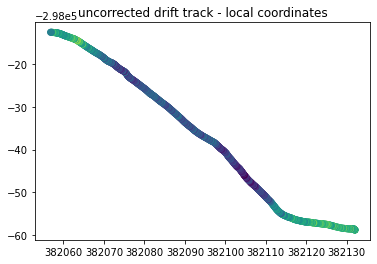

In [86]:
plt.scatter(gem2easting[0:1000], gem2northing[0:1000], c = f1530hz_hcp_i[0:1000])
plt.title("uncorrected drift track - local coordinates")

In [87]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour))*3600.0) + (int(minute) * 60.0) + float(second))
    
gem2dayseconds = np.array(gem2dayseconds)

In [88]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [89]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

41471.4375
29024
47110


In [90]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [91]:
gnssdayseconds = np.array(gnssdayseconds)

In [92]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [93]:
trimmedtime[0]

41471.0

In [94]:
gem2dayseconds[0]

41471.4375

In [95]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [96]:
timesteps = np.round(timesteps, 4)

In [97]:
timesteps[0]

41470.5

In [98]:
gem2dayseconds[0]

41471.4375

In [99]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 42min 56s, sys: 5min 12s, total: 48min 9s
Wall time: 48min 25s


In [100]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

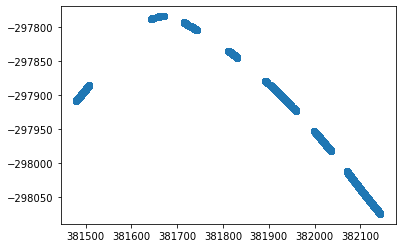

In [101]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [102]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [103]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [104]:
local_gem2_east[0]

-11.752706311293878

In [105]:
local_gem2_north[0]

15.975117125897668

In [106]:
world_gem2_east = local_gem2_east + ref_point_east
world_gem2_north = local_gem2_north + ref_point_north

In [107]:
world_gem2_north

array([-299129.80941357, -299129.81832556, -299129.82711464, ...,
       -299128.60018761, -299128.5821119 , -299128.56470778])

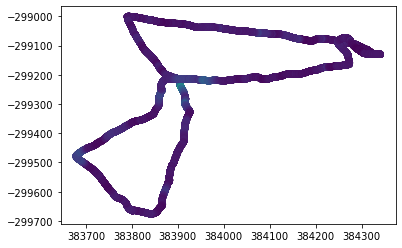

In [108]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i)

In [109]:
gem2_header = """AeN JC2-2 2021 P9 GEM2 measurements
GEM2-531 electromagnetic induction sounder
7 September 2021\nAdam Steer / Anca Cristea
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [110]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [111]:
gem2out = gem2data.copy()

In [112]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [113]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [114]:
gem2out.insert(2, "easting", world_gem2_east)

In [115]:
gem2out.insert(3, "northing", world_gem2_north)

In [116]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [117]:
gem2out

time   record_id        easting       northing  \
7      2021-09-07T11:31:11.437500           7  384340.995131 -299129.809414   
8      2021-09-07T11:31:11.539062           8  384341.006103 -299129.818326   
9      2021-09-07T11:31:11.640625           9  384341.017066 -299129.827115   
10     2021-09-07T11:31:11.742187          10  384341.028041 -299129.835912   
11     2021-09-07T11:31:11.835937          11  384341.038162 -299129.844026   
...                           ...         ...            ...            ...   
31413  2021-09-07T14:01:53.546875       31413  384331.878648 -299128.642588   
31414  2021-09-07T14:01:53.640625       31414  384331.922271 -299128.625184   
31415  2021-09-07T14:01:53.750000       31415  384331.958477 -299128.600188   
31416  2021-09-07T14:01:53.843750       31416  384332.002626 -299128.582112   
31417  2021-09-07T14:01:53.937500       31417  384332.046249 -299128.564708   

        xc   yc   f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
7      0.0  0.0          1.885         1.554          1.596          1.518   
8      0.0  0.0          0.982         1.648          1.402          1.520   
9      0.0  0.0          1.717         1.566          1.447          1.485   
10     0.0  0.0          2.112         1.459          1.602          1.483   
11     0.0  0.0          2.045         1.502          1.631          1.496   
...    ...  ...            ...           ...            ...            ...   
31413  0.0  0.0          2.089         1.521          1.467          1.562   
31414  0.0  0.0          1.422         1.482          1.423          1.579   
31415  0.0  0.0          1.401         1.582          1.417          1.550   
31416  0.0  0.0          1.514         1.551          1.500          1.551   
31417  0.0  0.0          2.070         1.459          1.512          1.568   

       f5310Hz_hcp_i  f5310Hz_hcp_q  f18330Hz_hcp_i  f18330Hz_hcp_q  \
7              1.504          1.499           1.507           1.488   
8              1.516          1.503           1.505           1.491   
9              1.528          1.503           1.505           1.495   
10             1.534          1.501           1.505           1.496   
11             1.543          1.502           1.504           1.496   
...              ...            ...             ...             ...   
31413          1.551          1.553           1.558           1.560   
31414          1.550          1.558           1.553           1.558   
31415          1.554          1.558           1.546           1.558   
31416          1.550          1.559           1.550           1.559   
31417          1.555          1.562           1.550           1.562   

       f63030Hz_hcp_i  f63030Hz_hcp_q  
7               1.501           1.484  
8               1.501           1.486  
9               1.501           1.487  
10              1.500           1.488  
11              1.500           1.489  
...               ...             ...  
31413           1.554           1.570  
31414           1.552           1.570  
31415           1.552           1.570  
31416           1.555           1.570  
31417           1.557           1.571  

[31053 rows x 16 columns]

In [118]:
gem2_output = "/mnt/documents/JC2-2/P9-06092021/gem2/07092021/GEM2data-07092021-driftcorrected-afternoon.csv"

In [119]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [120]:
gem2out.to_csv(gem2_output, index=False, mode='a')

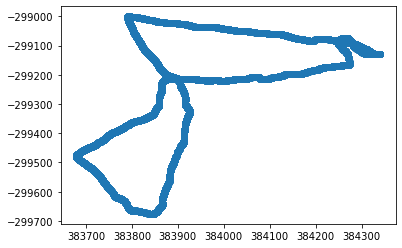

In [121]:
plt.scatter(world_gem2_east, world_gem2_north)




## Load Magnaprobe data to be drift corrected

Using the NPI magnaprobe, add 1024 weeks to timestamps

In [122]:
magnaprobeinputfile = "/mnt/documents/JC2-2/P9-06092021/magnaprobe/07092021/NPI2.dat"

In [123]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [124]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [125]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [126]:
weekdelta = timedelta(weeks=1024)

In [127]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [128]:
mpdaysfixed[0].day

5

In [129]:
# find just this day..
todays_times = []
i = 0
for thisday in mpdaysfixed:
    if thisday.day == 7:
        todays_times.append(i)
    i+=1
todays_times = np.array(todays_times)

In [130]:
todays_times

array([  34,   35,   36, ..., 4098, 4099, 4100])

In [131]:
mptimes = mptimes[todays_times]

In [132]:
mpdays = np.array(mpdays)[todays_times]


In [133]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [134]:
mp_dayseconds = np.round(mp_dayseconds, 2)
mp_dayseconds

array([29417.4 , 29419.45, 29422.45, ..., 50564.14, 50565.81, 50566.75])

In [135]:
gnssdayseconds

array([26959. , 26959.5, 26960. , ..., 51391.5, 51392. , 51392.5])

In [136]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

29417.4
4916
47216


In [137]:
gnssdayseconds = np.array(gnssdayseconds)

In [138]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [139]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [140]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 8.98 s, sys: 15.1 ms, total: 9 s
Wall time: 9.01 s


In [141]:
len(timeindexes)

4067

In [142]:
len(mp_dayseconds)

4067

In [143]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [144]:
mplatddd = mpdata["latitude_a"].values[todays_times] + (mpdata["latitude_b"].values[todays_times] / 60)
mplonddd = mpdata["Longitude_a"].values[todays_times] + (mpdata["Longitude_b"].values[todays_times] / 60)

In [145]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [146]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

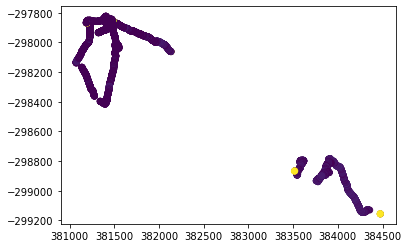

In [147]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"][todays_times])

In [149]:
mpeasting[0]

384476.50047745375

In [150]:
mpnorthing[0]

-299155.9930512102

Do the drift correction to local coordinates

In [151]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [152]:
len(mpeasting)

4067

In [153]:
len(gnss_mp_match_eastings)

4067

Convert back to world coordinates

In [154]:
world_mp_east = local_mp_east + ref_point_east
world_mp_north = local_mp_north + ref_point_north

In [155]:
world_mp_north

array([-299127.74712789, -299127.60098559, -299127.62841991, ...,
       -299121.99801842, -299121.96433034, -299121.34321928])

In [156]:
world_mp_east

array([384342.57720255, 384342.63608682, 384342.39693969, ...,
       384345.16101842, 384345.91930815, 384346.65948579])

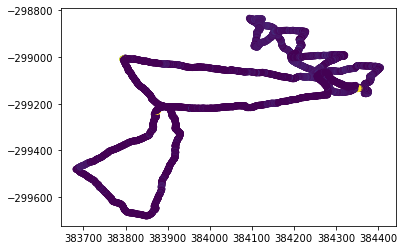

In [157]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"][todays_times])

Export data to CSV

In [158]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdays[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [159]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"][todays_times]/100   })

In [160]:
mp_export

timestamp        easting       northing  snowdepth
34     22-01-2002T08:10:17.4  384342.577203 -299127.747128     1.2100
35    22-01-2002T08:10:19.45  384342.636087 -299127.600986     1.2100
36    22-01-2002T08:10:22.45  384342.396940 -299127.628420    -0.0001
37    22-01-2002T08:10:24.83  384342.460824 -299127.610583     1.2100
38    22-01-2002T08:10:25.85  384342.355037 -299127.565841     1.2100
...                      ...            ...            ...        ...
4096  22-01-2002T14:02:39.76  384341.703759 -299123.924696     0.0010
4097  22-01-2002T14:02:43.01  384344.076102 -299123.053290     0.0010
4098  22-01-2002T14:02:44.14  384345.161018 -299121.998018     0.0010
4099  22-01-2002T14:02:45.81  384345.919308 -299121.964330     0.0010
4100  22-01-2002T14:02:46.75  384346.659486 -299121.343219     0.0010

[4067 rows x 4 columns]

In [161]:
mp_output = "/mnt/documents/JC2-2/P9-06092021/magnaprobe/jc2-2-P9-07092021-magnaprobe.csv"

In [162]:
mp_header = """AeN JC2-2 P9 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
9 May 2021\nAdam Steer / Anca Cristea
Time corrected: added 1024 weeks to timestamp accounting for 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [163]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [164]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

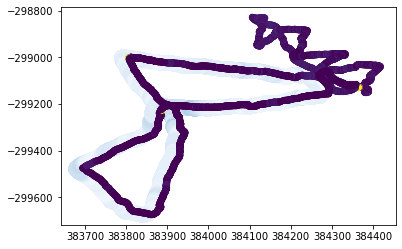

In [165]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"][todays_times]/100)

## Load camera centers to be drift corrected

In [166]:
cameracentrefile = "/mnt/documents/ANAFI-USA/jc2-2/08092021-jc2-2-p9/cameracenters.csv"

In [167]:
cameradata = pd.read_csv(cameracentrefile)

In [168]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [169]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [170]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

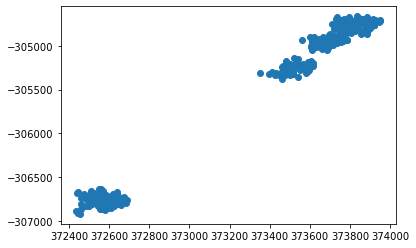

In [171]:
plt.scatter(cameraeasting, cameranorthing)

In [172]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    ./jpg/P1263687.JPG  2021:09:08 09:32:39                 449    85.549131   
1    ./jpg/P1263688.JPG  2021:09:08 09:32:42                 577    85.549130   
2    ./jpg/P1263689.JPG  2021:09:08 09:32:46                  35    85.549130   
3    ./jpg/P1263690.JPG  2021:09:08 09:32:48                 616    85.549130   
4    ./jpg/P1263691.JPG  2021:09:08 09:32:58                 987    85.549129   
..                  ...                  ...                 ...          ...   
351  ./jpg/P1344040.JPG  2021:09:08 15:09:48                  34    85.546731   
352  ./jpg/P1344041.JPG  2021:09:08 15:09:56                 712    85.546512   
353  ./jpg/P1344042.JPG  2021:09:08 15:10:03                 115    85.546326   
354  ./jpg/P1344043.JPG  2021:09:08 15:10:06                 107    85.546414   
355  ./jpg/P1344044.JPG  2021:09:08 15:10:11                 808    85.546512   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0        5.818478    11.389436             8.233777       0.963328   
1        5.818497    16.231480            13.972556       0.998248   
2        5.818505    22.018221            20.228691       0.927631   
3        5.818504    26.362392            25.486193       0.885268   
4        5.818498    44.046719            46.961754       0.723464   
..            ...          ...                  ...            ...   
351      5.528611    45.918579            45.790134       0.940479   
352      5.521988    46.790810            45.768795       0.834386   
353      5.523673    42.515289            42.862808       0.778332   
354      5.523720    34.396877            36.340240       0.820366   
355      5.522284    23.405121            22.382744       0.750067   

     GPSZAccuracy  CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0             2.3         -79.297241         -0.214893      -113.903519  
1             2.4         -80.921753          0.025165      -114.093010  
2             2.2         -81.165291         -0.038258      -114.074173  
3             2.1         -81.161270         -0.113847      -113.944931  
4             1.9         -81.178413          0.133507      -114.164444  
..            ...                ...               ...              ...  
351           2.0         -79.750587         -0.850560        22.307911  
352           1.8         -79.458557         -0.940673        53.346195  
353           1.7         -79.786674         -0.000413        10.447741  
354           1.8         -79.750626         -0.178893         8.968339  
355           1.6         -79.748787         -0.034502         9.979959  

[356 rows x 12 columns]

In [173]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [174]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [175]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.449, 0.577, 0.35, 0.616, 0.987]

In [176]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [177]:
cam_dayseconds[-1]

47400.808

In [178]:
min(cam_dayseconds)

27120.35

In [229]:
cam_glon, cam_glat, cam_gtimes = readbasegps("/mnt/documents/JC2-2/P9-06092021/gnss/base3-near/kppp/07092021-base3-day3.pos")

['2021/09/08 07:01:50.0000000' '2021/09/08 07:01:50.5000000'
 '2021/09/08 07:01:51.0000000' '2021/09/08 07:01:51.5000000']


In [231]:
cam_gnssdayseconds=[]
for thetime in cam_gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    cam_gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
    
cam_gnssdayseconds = np.array(cam_gnssdayseconds)

In [232]:
cam_gnss_trimmedtime,start,end = trim_timeseries(cam_gnssdayseconds, cam_dayseconds)

27120.449
3620
44182


In [233]:
len(cam_gnss_trimmedtime)

40563

In [241]:
cam_gnssutm = thetransform.transform(cam_glat, cam_glon)
cam_gnssutm = np.array(cam_gnssutm)

In [242]:
cam_trimmedeast = np.squeeze(cam_gnssutm[0][cam_gnss_trimmedtime])
cam_trimmednorth = np.squeeze(cam_gnssutm[1][cam_gnss_trimmedtime])
cam_trimmedtime = np.squeeze(cam_gnssdayseconds[cam_gnss_trimmedtime])

In [243]:
len(cam_trimmedeast)

40563

In [244]:
min(cam_dayseconds)

27120.35

In [245]:
max(cam_dayseconds)

47400.808

In [246]:
min(cam_gnssdayseconds)

25310.0

In [247]:
max(cam_gnssdayseconds)

47844.0

In [248]:
timesteps = np.arange(cam_trimmedtime.min()-0.5, cam_trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

cam_interp_east = np.interp(timesteps, cam_trimmedtime, cam_trimmedeast)
cam_interp_north = np.interp(timesteps, cam_trimmedtime, cam_trimmednorth)

In [249]:
cam_interp_north

array([-304914.30896074, -304914.30896074, -304914.30896074, ...,
       -306863.86126938, -306863.86126938, -306863.86126938])

In [250]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 3.62 s, sys: 14 µs, total: 3.62 s
Wall time: 3.62 s


In [251]:
gnss_cam_match_eastings = np.squeeze(cam_interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(cam_interp_north[timeindexes])

In [252]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [253]:
local_cam_east[0]

-184.2713331762352

In [254]:
local_cam_north[0]

154.42415502440417

In [255]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

1949.4619435321656

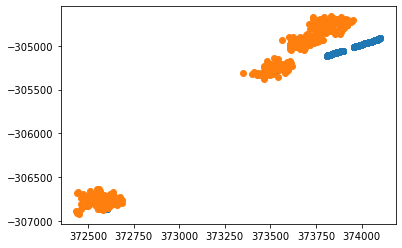

In [257]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting, cameranorthing)

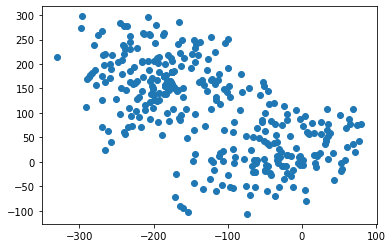

In [258]:
plt.scatter(local_cam_east, local_cam_north)

In [259]:
gnss_gem2_match_eastings[0]

382143.7467892712

In [260]:
local_gem2_east[0]

-11.752706311293878

In [261]:
world_cam_east = local_cam_east + gnss_cam_match_eastings[0]
world_cam_north = local_cam_north + gnss_cam_match_northings[0]

In [262]:
world_cam_east[0]

373918.7462688719

In [263]:
world_cam_north[0]

-304759.93997292855

In [264]:
world_mp_north[0]

-299127.7471278931

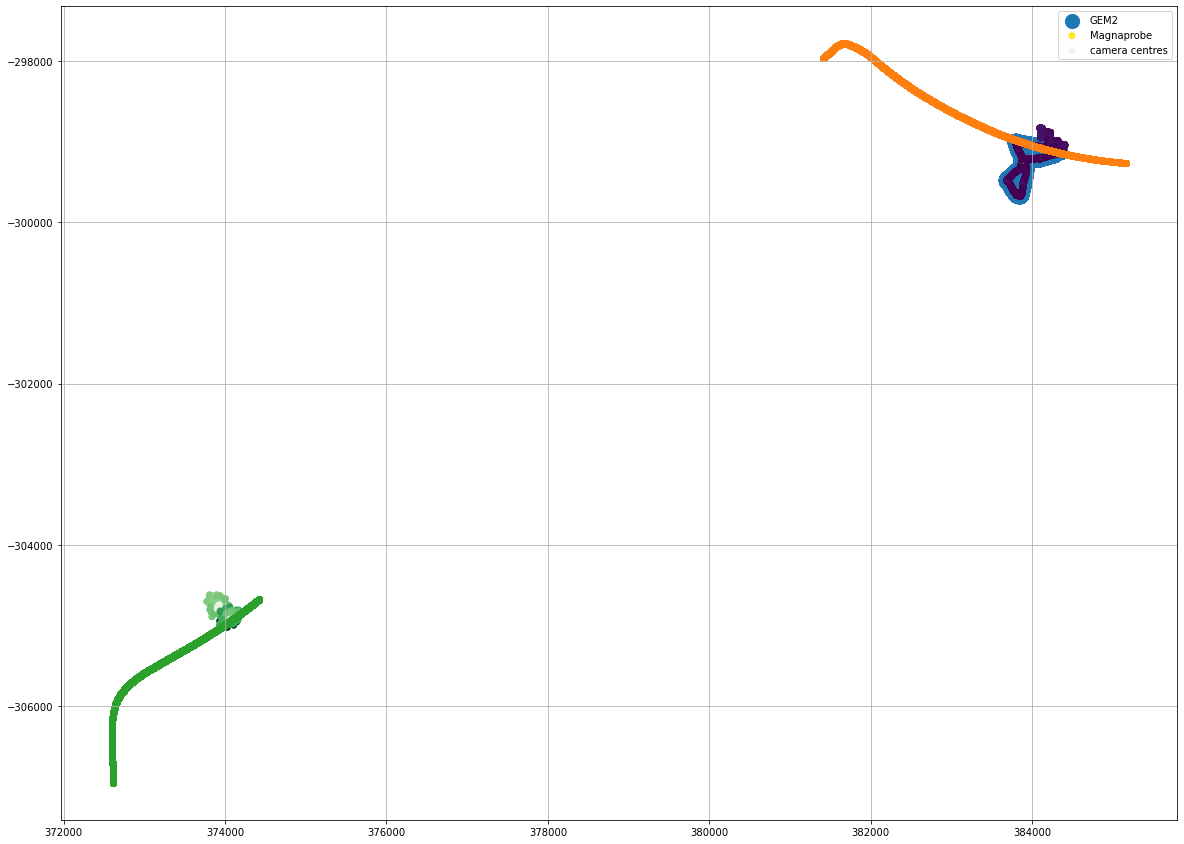

In [265]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"][todays_times]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.scatter(gnssutm[0], gnssutm[1])
plt.scatter(cam_gnssutm[0], cam_gnssutm[1])
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/JC2-2/P9-06092021/corrected-tracks.png")

In [266]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [267]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [268]:
cam_out = cameradata.copy()

In [269]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [270]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [271]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/jc2-2/08092021-jc2-2-p9/driftcorrected-for-exiftool.csv"

In [272]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [273]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

0.0

In [274]:
cam_out['GPSLatitude'][0]

85.5491310994167

In [275]:
cam_out_hag = cam_out.copy()

In [276]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [277]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [278]:
cam_out_hag

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    ./jpg/P1263687.JPG  2021:09:08 09:32:39                 449    85.549131   
1    ./jpg/P1263688.JPG  2021:09:08 09:32:42                 577    85.549130   
2    ./jpg/P1263689.JPG  2021:09:08 09:32:46                  35    85.549130   
3    ./jpg/P1263690.JPG  2021:09:08 09:32:48                 616    85.549130   
4    ./jpg/P1263691.JPG  2021:09:08 09:32:58                 987    85.549129   
..                  ...                  ...                 ...          ...   
351  ./jpg/P1344040.JPG  2021:09:08 15:09:48                  34    85.547384   
352  ./jpg/P1344041.JPG  2021:09:08 15:09:56                 712    85.547167   
353  ./jpg/P1344042.JPG  2021:09:08 15:10:03                 115    85.547044   
354  ./jpg/P1344043.JPG  2021:09:08 15:10:06                 107    85.547131   
355  ./jpg/P1344044.JPG  2021:09:08 15:10:11                 808    85.547231   

     GPSLongitude  GPSAltitude  GPSXYAccuracy  GPSZAccuracy  \
0        5.818478     8.233777       0.963328           2.3   
1        5.818500    13.972556       0.998248           2.4   
2        5.818502    20.228691       0.927631           2.2   
3        5.818508    25.486193       0.885268           2.1   
4        5.818511    46.961754       0.723464           1.9   
..            ...          ...            ...           ...   
351      5.819221    45.790134       0.940479           2.0   
352      5.812589    45.768795       0.834386           1.8   
353      5.815268    42.862808       0.778332           1.7   
354      5.815321    36.340240       0.820366           1.8   
355      5.813903    22.382744       0.750067           1.6   

     CameraPitchDegree  CameraRollDegree  CameraYawDegree  
0           -79.297241         -0.214893      -113.903519  
1           -80.921753          0.025165      -114.093010  
2           -81.165291         -0.038258      -114.074173  
3           -81.161270         -0.113847      -113.944931  
4           -81.178413          0.133507      -114.164444  
..                 ...               ...              ...  
351         -79.750587         -0.850560        22.307911  
352         -79.458557         -0.940673        53.346195  
353         -79.786674         -0.000413        10.447741  
354         -79.750626         -0.178893         8.968339  
355         -79.748787         -0.034502         9.979959  

[356 rows x 11 columns]

In [279]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/jc2-2/08092021-jc2-2-p9/driftcorrected-for-exiftool-HAG.csv"

In [280]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)

In [281]:
cameradata["GPSLatitude"][0]

85.5491310994167

In [282]:
cameradata["GPSLongitude"][0]

5.81847787925

In [283]:
cam_out_hag["GPSLatitude"][0]

85.5491310994167

In [284]:
cam_out_hag["GPSLongitude"][0]

5.818477879250007

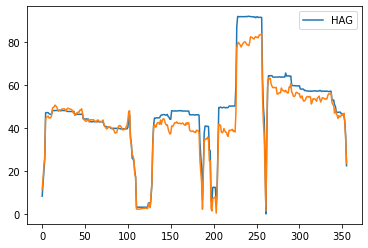

In [285]:
plt.plot(cam_out_hag["GPSAltitude"], label = "HAG")
plt.plot(cam_out["GPSAltitude"])
plt.legend()

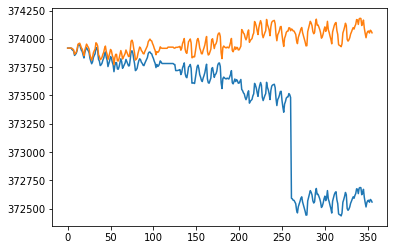

In [288]:
plt.plot(cameraeasting)
plt.plot(world_cam_east)

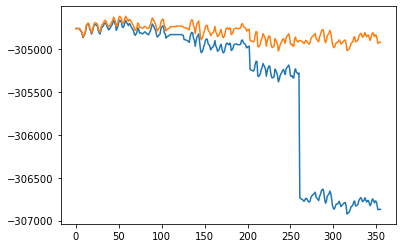

In [289]:
plt.plot(cameranorthing)
plt.plot(world_cam_north)